<a href="https://colab.research.google.com/github/HromovAndrey/II_mood_6_part2.1/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Завдання

[Посилання](https://www.kaggle.com/datasets/banuprakashv/news-articles-classification-dataset-for-nlp-and-ml/data)

За допомогою `pytorch` проведіть класифікацію тексту:

* Завантажте усі датафрейми
* Добавте до кожного стовпчик `labels` з відповідним йому класом(bussiness, sports, education, etc). назви класів беріть з назв файлів
* Об'єднайте всі датафрейми в один, див [pd.concat](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)
* Створіть стовпчик `text` в якому зберігатиметься текст для подальшої роботи. Можети вибрати такі варіанти:
  * Взяти один зі стовпчиків `headline`, `description`, `content`
  * Об'єднати тексти зі стовпчиків `headline`, `description`, `content`
* Видаліть стовпчики `headline`, `description`, `content`, `url`
* Створіть датасет з використанням `Glove`
* Перевірте розмірність даних у датасеті
* Розділіть дані на тренувальні та тестові, створіть `data_loader`
* Створіть модель та натренуйте її
* Виведіть результати класифікації

In [1]:

!pip install torch==2.0.1 torchtext==0.15.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98

In [2]:
import pandas as pd
import zipfile
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import GloVe
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch import nn
import torch.nn.functional as F
import numpy as np
import math

from torch import Tensor

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
df = pd.read_csv("/content/business_data.csv.zip")

In [11]:
print(df.columns)

Index(['headlines', 'description', 'content', 'url', 'category'], dtype='object')


In [12]:
text_column = 'content'
label_column = 'category'

In [13]:
class MyDataset(Dataset):
    def __init__(self, X, y, max_len=100):
        self.X = X
        self.y = y
        self.max_len = max_len

        self.label_encoder = LabelEncoder().fit(y)

        # Загрузка GloVe
        self.vocab = GloVe(name='6B', dim=50)  # Загрузите GloVe из torchtext

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        label = self.label_encoder.transform([self.y.iloc[idx]])
        label = torch.tensor(label)

        text = self.X.iloc[idx]
        tokens = text.split()

        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
        else:
            diff = self.max_len - len(tokens)
            tokens += [''] * diff

        X = self.vocab.get_vecs_by_tokens(tokens, lower_case_backup=True)
        return X, label[0]

# Используем правильные столбцы для создания набора данных
dataset = MyDataset(df[text_column], df[label_column])

print(f'Длина датасета: {len(dataset)}')

Длина датасета: 2000


In [14]:
dataset[0][0].shape

torch.Size([100, 50])

In [15]:
train_ratio = 0.8

train_data, test_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [16]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [17]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:

        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [18]:
class TextClassifier(nn.Module):
    def __init__(self, encoding_dim, max_len, num_classes):
        super().__init__()

        self.pos_encoder = PositionalEncoding(d_model=encoding_dim, max_len=max_len)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=encoding_dim, nhead=2, batch_first=True, dim_feedforward=64),
            num_layers=1
        )

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(encoding_dim*max_len, num_classes)

    def forward(self, x):
        out = self.pos_encoder(x)
        out = self.encoder(out)
        out = self.flatten(out)
        out = self.linear1(out)
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()


model = TextClassifier(encoding_dim=50, max_len=100, num_classes=5).to(device)
model

TextClassifier(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=50, bias=True)
        (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=5000, out_features=5, bias=True)
)

In [19]:
params_num = 0

for param in model.parameters():
    size = param.size()

    num = 1
    for item in size:
        num *= item
    params_num += num

params_num

41919

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [22]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)


        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()



    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [23]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=TextClassifier, opt=AdamW(lr=0.000100), epochs=10, device=cpu

Epoch    1    8sec	loss:     0.0574	val_loss:   0.000191	accuracy_score:      0.994	val_accuracy_score:          1	
Epoch    2    5sec	loss:   0.000336	val_loss:   0.000155	accuracy_score:          1	val_accuracy_score:          1	
Epoch    3    3sec	loss:   0.000291	val_loss:   0.000133	accuracy_score:          1	val_accuracy_score:          1	
Epoch    4    3sec	loss:   0.000249	val_loss:   0.000114	accuracy_score:          1	val_accuracy_score:          1	
Epoch    5    4sec	loss:   0.000216	val_loss:   9.75e-05	accuracy_score:          1	val_accuracy_score:          1	
Epoch    6    3sec	loss:   0.000187	val_loss:   8.37e-05	accuracy_score:          1	val_accuracy_score:          1	
Epoch    7    3sec	loss:   0.000163	val_loss:   7.23e-05	accuracy_score:          1	val_accuracy_score:          1	
Epoch    8    3sec	loss:   0.000141	val_loss:   6.31e-05	accuracy_score:          1	val_accuracy_score:

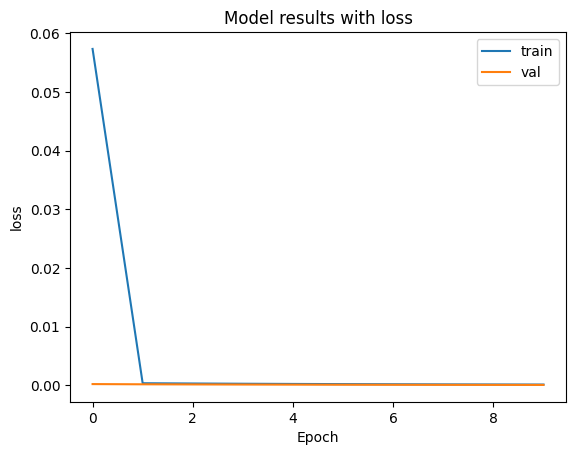

In [24]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

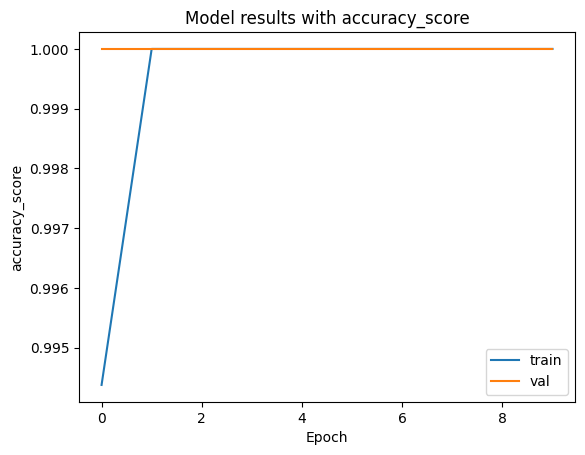

In [25]:
plot_metric(history, 'accuracy_score')

[]

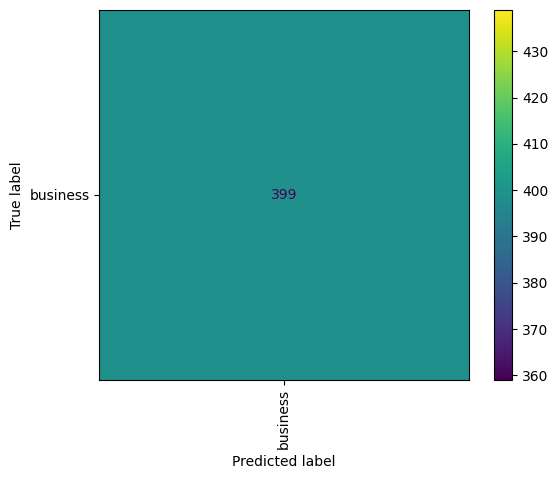

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')  # відключаємо від gpu

loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=dataset.label_encoder.classes_)
plt.xticks(rotation=90)
plt.plot()

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.argmax(-1), target_names=dataset.label_encoder.classes_))

              precision    recall  f1-score   support

    business       1.00      1.00      1.00       399

    accuracy                           1.00       399
   macro avg       1.00      1.00      1.00       399
weighted avg       1.00      1.00      1.00       399

